### 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

os.chdir('/content/drive/MyDrive/신입기수 프로젝트/Dataset')

In [ ]:
df = pd.read_csv('rawdata.csv')

In [ ]:
df.columns

Index(['날짜', '현재수위', '유입량', '저수량', '공용량', '방류량', '강화대교_조위', '청담대교_유량',
       '잠수교_유량', '한강대교_유량', '행주대교_유량', '대곡교_강수량', '진관교_강수량', '송정동_강수량',
       '청담대교_수위', '잠수교_수위', '한강대교_수위', '행주대교_수위'],
      dtype='object')

In [ ]:
df_arima = df[['날짜', '공용량', '현재수위', '방류량']]

In [ ]:
df_arima

,날짜,공용량,현재수위,방류량
0,2012-05-01 00:00,24.93,24.800,555.00
1,2012-05-01 00:10,25.15,24.794,562.90
2,2012-05-01 00:20,25.31,24.789,576.40
3,2012-05-01 00:30,25.31,24.789,563.10
4,2012-05-01 00:40,25.31,24.789,576.40
...,...,...,...,...
276331,2022-07-18 23:10,31.14,25.040,259.23
276332,2022-07-18 23:20,31.14,25.040,260.46
276333,2022-07-18 23:30,31.14,25.040,259.37
276334,2022-07-18 23:40,31.14,25.040,259.13


In [ ]:
df_arima.index

RangeIndex(start=0, stop=276336, step=1)

In [ ]:
# rangeindex를 int64 인덱스로 바꿔주기 (rangeindex일 경우에는 isnull 조건에 맞는 컬럼 추출이 불가능하기 때문)
df_arima.index = list(df_arima.index)
df_arima.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            276326, 276327, 276328, 276329, 276330, 276331, 276332, 276333,
            276334, 276335],
           dtype='int64', length=276336)

### 결측치 확인하기

In [ ]:
# 결측치 처리할 컬럼

col = ['공용량', '현재수위', '방류량']

In [ ]:
# 결측치 인덱스 확인 (df_arima[i].isnull().index는 안되고 다음과 같이 앞에 df_arima를 한번 더 붙여주면 됨!)

for i in col:
  print(df_arima[df_arima[i].isnull()].index)
  print('------------------------')

Int64Index([ 13200,  68081,  68083,  68084,  68085,  68086,  68087,  68089,
             68090,  68091,
            ...
            270533, 270534, 271588, 272215, 272216, 272217, 272218, 272219,
            272220, 272221],
           dtype='int64', length=743)
------------------------
Int64Index([ 13200,  68081,  68083,  68084,  68085,  68086,  68087,  68089,
             68090,  68091,
            ...
            270533, 270534, 271588, 272215, 272216, 272217, 272218, 272219,
            272220, 272221],
           dtype='int64', length=743)
------------------------
Int64Index([ 13200,  68081,  68083,  68084,  68085,  68086,  68087,  68089,
             68090,  68091,
            ...
            270533, 270534, 271588, 272215, 272216, 272217, 272218, 272219,
            272220, 272221],
           dtype='int64', length=743)
------------------------


In [ ]:
# 결측치인 row가 모두 겹치는지 확인
all(df_arima[df_arima[col[0]].isnull()].index == df_arima[df_arima[col[1]].isnull()].index)
all(df_arima[df_arima[col[0]].isnull()].index == df_arima[df_arima[col[2]].isnull()].index)

True

### 연속-불연속 결측치 리스트 만들기

In [ ]:
nanIndex = df_arima[df_arima['현재수위'].isnull()].index
nanIndex

Int64Index([ 13200,  68081,  68083,  68084,  68085,  68086,  68087,  68089,
             68090,  68091,
            ...
            270533, 270534, 271588, 272215, 272216, 272217, 272218, 272219,
            272220, 272221],
           dtype='int64', length=743)

In [ ]:
unconsecutive = []
consecutive = []

i = 0
while i < len(nanIndex):
    if nanIndex[i]+1 in nanIndex: # 다음 거가 nanIndex 안에 있으면 다음 거까지 consecutive에 추가
        consecutive.extend([nanIndex[i], nanIndex[i+1]])
        try:
            i += 2
        except: #i가 len(nanIndex2) - 1
            break
    elif nanIndex[i]-1 in nanIndex: #다음 거는 nanIndex 안에 없지만 consecutive로 들어가야 하는 경우(반복 구간의 마지막 원소)
        consecutive.append(nanIndex[i])
        i += 1
    else:
        unconsecutive.append(nanIndex[i])
        i += 1

In [ ]:
print(len(consecutive), consecutive)
print(len(unconsecutive), unconsecutive)

626 [68083, 68084, 68085, 68086, 68087, 68089, 68090, 68091, 68092, 68093, 68095, 68096, 68097, 68098, 68099, 68101, 68102, 68103, 68104, 81560, 81561, 81562, 81563, 81565, 81566, 81567, 81568, 123622, 123623, 123625, 123626, 123627, 123628, 123629, 132986, 132987, 132988, 132989, 132991, 132992, 132993, 132994, 132995, 132997, 132998, 132999, 133003, 133004, 156158, 156159, 165428, 165429, 165430, 165431, 165432, 165433, 165434, 165435, 165436, 165437, 165438, 165439, 165440, 165441, 165442, 165443, 165444, 165445, 165446, 165447, 165448, 165449, 165450, 165451, 165452, 165453, 165454, 165455, 165456, 165457, 165458, 165459, 165460, 165461, 165462, 165463, 165464, 165465, 166263, 166264, 174173, 174174, 186388, 186389, 186390, 186391, 186424, 186425, 186426, 186427, 186428, 186429, 186430, 186431, 186432, 186433, 186434, 186435, 186436, 186437, 186438, 186439, 186440, 186441, 186442, 186443, 186444, 186445, 186446, 186447, 186448, 186449, 186450, 186451, 186452, 186453, 186454, 186455

In [ ]:
# consecutive 내에서 구간별로 분리
dummy = []
consecutive2 = [] # 2차원 consecutive
for i in consecutive: 
    dummy.append(i)
    if i+1 not in consecutive:
        if i == consecutive[-2]: #만약 마지막 반복일 경우, consecutive[-1]을 추가로 넣어주어야 함
            dummy.append(i+1)
            consecutive2.append(dummy)
        else: 
            consecutive2.append(dummy)
            dummy= []   

In [ ]:
# 2차원 consecutive의 모양 확인(길이, 첫index, 끝index)
for i in range(len(consecutive2)):
    print(len(consecutive2[i]), consecutive2[i][0], consecutive2[i][-1])

5 68083 68087
5 68089 68093
5 68095 68099
4 68101 68104
4 81560 81563
4 81565 81568
2 123622 123623
5 123625 123629
4 132986 132989
5 132991 132995
3 132997 132999
2 133003 133004
2 156158 156159
38 165428 165465
2 166263 166264
2 174173 174174
4 186388 186391
113 186424 186536
50 187213 187262
14 187384 187397
2 187713 187714
34 192274 192307
4 203942 203945
43 206949 206991
22 207111 207132
42 207141 207182
45 207375 207419
4 208247 208250
74 208252 208325
22 209877 209898
5 209908 209912
6 214982 214987
4 250924 250927
4 253462 253465
4 261268 261271
3 262598 262600
28 270507 270534


### 보간처리

In [ ]:
# 보간처리를 위해 앞뒤 인덱스를 포함한 unconsecutive2 인덱스
unconsecutive2 = sum([[i-1, i, i+1] for i in unconsecutive], [])
# sum(list, []) : to unfold the list

In [ ]:
# 겹치는 인덱스가 없는지 확인
len(unconsecutive2) == len(unconsecutive) * 3

True

In [ ]:
# 데이터프레임 분리
df_intp = df_arima.copy()
df_intp = df_intp.iloc[unconsecutive2, :]
df_intp

,날짜,공용량,현재수위,방류량
13199,2012-07-31 15:50,13.62,25.121,775.40
13200,2012-07-31 16:00,NaN,NaN,NaN
13201,2012-07-31 16:10,13.91,25.113,777.60
68080,2014-08-13 18:40,13.67,25.120,776.80
68081,2014-08-13 18:50,NaN,NaN,NaN
...,...,...,...,...
261266,2021-10-06 08:20,NaN,NaN,NaN
261267,2021-10-06 08:30,34.40,24.950,336.00
271587,2022-06-16 00:30,26.01,25.180,137.33
271588,2022-06-16 00:40,NaN,NaN,NaN


In [ ]:
# 보간
df_intp.interpolate(inplace=True)
df_intp   # 보간 결과 확인

,날짜,공용량,현재수위,방류량
13199,2012-07-31 15:50,13.620,25.121,775.400
13200,2012-07-31 16:00,13.765,25.117,776.500
13201,2012-07-31 16:10,13.910,25.113,777.600
68080,2014-08-13 18:40,13.670,25.120,776.800
68081,2014-08-13 18:50,13.670,25.120,762.400
...,...,...,...,...
261266,2021-10-06 08:20,34.400,24.950,335.000
261267,2021-10-06 08:30,34.400,24.950,336.000
271587,2022-06-16 00:30,26.010,25.180,137.330
271588,2022-06-16 00:40,26.010,25.180,156.305


In [ ]:
# 결측치 없는지 확인
df_intp.isnull().sum()

날짜      0
공용량     0
현재수위    0
방류량     0
dtype: int64

In [ ]:
# 보간처리한 row들을 df_arima에 합치기
for i in col:
  df_arima.loc[unconsecutive2, [i]] = df_intp.loc[:, [i]]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [ ]:
# 남은 결측치 개수가 SARIMA로 채워야 할 결측치 개수(len(consecutive))와 같은지 확인
df_arima.isnull().sum() == len(consecutive)

날짜      False
공용량      True
현재수위     True
방류량      True
dtype: bool

### Arima

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [ ]:
df_arima[col[0]][consecutive2[0]]

68083   NaN
68084   NaN
68085   NaN
68086   NaN
68087   NaN
Name: 공용량, dtype: float64

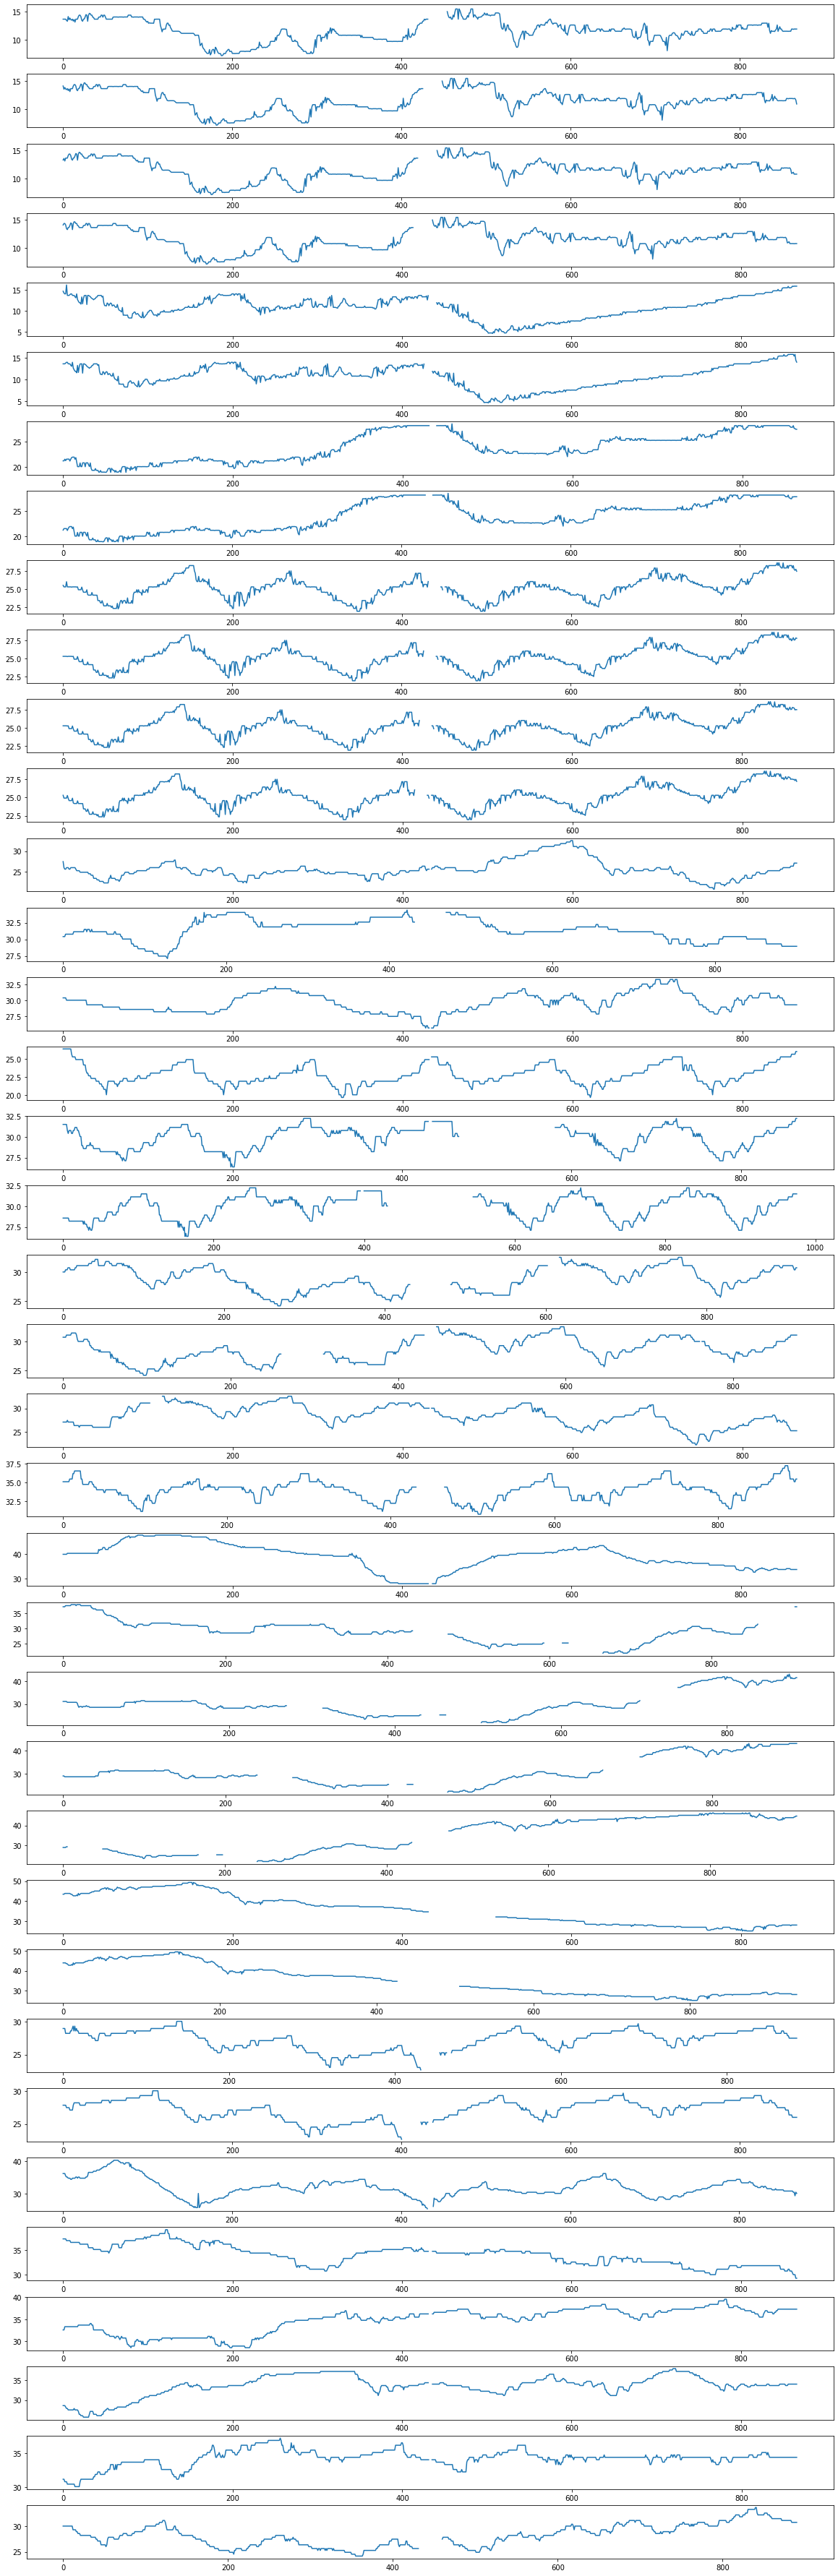

In [ ]:
f, axes = plt.subplots(len(consecutive2), 1)
f.set_size_inches((20, 65))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i in range(len(consecutive2)):
    start = consecutive2[i][0]-432
    end = consecutive2[i][-1]+432
    x = range(len(df_arima['날짜'][start:end]))
    y = df_arima['공용량'][start:end]
    axes[i].plot(x, y)

plt.show()

In [ ]:
df_arima

,날짜,공용량,현재수위,방류량
0,2012-05-01 00:00,24.93,24.800,555.00
1,2012-05-01 00:10,25.15,24.794,562.90
2,2012-05-01 00:20,25.31,24.789,576.40
3,2012-05-01 00:30,25.31,24.789,563.10
4,2012-05-01 00:40,25.31,24.789,576.40
...,...,...,...,...
276331,2022-07-18 23:10,31.14,25.040,259.23
276332,2022-07-18 23:20,31.14,25.040,260.46
276333,2022-07-18 23:30,31.14,25.040,259.37
276334,2022-07-18 23:40,31.14,25.040,259.13


In [ ]:
n = 100

for lst in consecutive2:
  for i in col: 
    start = lst[0]
    model = pm.auto_arima(df_arima[i][start-n:start], seasonal = True)
    df_arima[i].loc[lst] = model.predict(len(lst)).values
    print(f'{i} 컬럼의 {consecutive2.index(lst)+1}번째 구간 결측치 처리 완료')
    print(df_arima.loc[lst, i].isnull().index)
    print(model.predict(len(lst)))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 1번째 구간 결측치 처리 완료
Int64Index([68083, 68084, 68085, 68086, 68087], dtype='int64')
100    13.888663
101    14.005988
102    14.123313
103    14.240637
104    14.357962
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 1번째 구간 결측치 처리 완료
Int64Index([68083, 68084, 68085, 68086, 68087], dtype='int64')
100    25.114401
101    25.111922
102    25.108983
103    25.105588
104    25.102552
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 1번째 구간 결측치 처리 완료
Int64Index([68083, 68084, 68085, 68086, 68087], dtype='int64')
100    754.213131
101    760.426263
102    766.639394
103    772.852525
104    779.065657
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 2번째 구간 결측치 처리 완료
Int64Index([68089, 68090, 68091, 68092, 68093], dtype='int64')
100    14.754226
101    14.886144
102    15.018061
103    15.149978
104    15.281895
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 2번째 구간 결측치 처리 완료
Int64Index([68089, 68090, 68091, 68092, 68093], dtype='int64')
100    25.091248
101    25.086970
102    25.082605
103    25.079561
104    25.075799
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 2번째 구간 결측치 처리 완료
Int64Index([68089, 68090, 68091, 68092, 68093], dtype='int64')
100    758.253535
101    764.507071
102    770.760606
103    777.014141
104    783.267677
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 3번째 구간 결측치 처리 완료
Int64Index([68095, 68096, 68097, 68098, 68099], dtype='int64')
100    15.790154
101    15.944459
102    16.098764
103    16.253070
104    16.407375
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 3번째 구간 결측치 처리 완료
Int64Index([68095, 68096, 68097, 68098, 68099], dtype='int64')
100    25.062076
101    25.056941
102    25.051736
103    25.048220
104    25.043778
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 3번째 구간 결측치 처리 완료
Int64Index([68095, 68096, 68097, 68098, 68099], dtype='int64')
100    759.263636
101    765.527273
102    771.790909
103    778.054545
104    784.318182
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 4번째 구간 결측치 처리 완료
Int64Index([68101, 68102, 68103, 68104], dtype='int64')
100    16.071578
101    16.169820
102    16.268063
103    16.366305
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 4번째 구간 결측치 처리 완료
Int64Index([68101, 68102, 68103, 68104], dtype='int64')
100    25.051558
101    25.050999
102    25.050568
103    25.046042
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 4번째 구간 결측치 처리 완료
Int64Index([68101, 68102, 68103, 68104], dtype='int64')
100    360.0
101    360.0
102    360.0
103    360.0
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 5번째 구간 결측치 처리 완료
Int64Index([81560, 81561, 81562, 81563], dtype='int64')
100    13.231291
101    13.376574
102    13.322273
103    13.342569
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 5번째 구간 결측치 처리 완료
Int64Index([81560, 81561, 81562, 81563], dtype='int64')
100    25.128152
101    25.128374
102    25.122244
103    25.131716
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 5번째 구간 결측치 처리 완료
Int64Index([81560, 81561, 81562, 81563], dtype='int64')
100    126.9
101    126.9
102    126.9
103    126.9
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 6번째 구간 결측치 처리 완료
Int64Index([81565, 81566, 81567, 81568], dtype='int64')
100    13.317218
101    13.310254
102    13.313071
103    13.311931
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 6번째 구간 결측치 처리 완료
Int64Index([81565, 81566, 81567, 81568], dtype='int64')
100    25.157300
101    25.161513
102    25.160115
103    25.160579
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 6번째 구간 결측치 처리 완료
Int64Index([81565, 81566, 81567, 81568], dtype='int64')
100    127.0
101    127.0
102    127.0
103    127.0
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 7번째 구간 결측치 처리 완료
Int64Index([123622, 123623], dtype='int64')
100    28.155538
101    28.138185
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 7번째 구간 결측치 처리 완료
Int64Index([123622, 123623], dtype='int64')
100    25.119615
101    25.119231
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 7번째 구간 결측치 처리 완료
Int64Index([123622, 123623], dtype='int64')
100    132.490083
101    132.490083
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 8번째 구간 결측치 처리 완료
Int64Index([123625, 123626, 123627, 123628, 123629], dtype='int64')
100    28.239848
101    28.273393
102    28.305985
103    28.338823
104    28.371598
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 8번째 구간 결측치 처리 완료
Int64Index([123625, 123626, 123627, 123628, 123629], dtype='int64')
100    25.119715
101    25.119430
102    25.119144
103    25.118859
104    25.118574
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 8번째 구간 결측치 처리 완료
Int64Index([123625, 123626, 123627, 123628, 123629], dtype='int64')
100    128.409668
101    128.409668
102    128.409668
103    128.409668
104    128.409668
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 9번째 구간 결측치 처리 완료
Int64Index([132986, 132987, 132988, 132989], dtype='int64')
100    25.815200
101    25.875909
102    25.858751
103    25.863601
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 9번째 구간 결측치 처리 완료
Int64Index([132986, 132987, 132988, 132989], dtype='int64')
100    25.179
101    25.179
102    25.179
103    25.179
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 9번째 구간 결측치 처리 완료
Int64Index([132986, 132987, 132988, 132989], dtype='int64')
100    120.249366
101    119.349216
102    119.411070
103    119.411070
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 10번째 구간 결측치 처리 완료
Int64Index([132991, 132992, 132993, 132994, 132995], dtype='int64')
100    25.703532
101    25.685480
102    25.690609
103    25.689152
104    25.689566
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 10번째 구간 결측치 처리 완료
Int64Index([132991, 132992, 132993, 132994, 132995], dtype='int64')
100    25.19
101    25.19
102    25.19
103    25.19
104    25.19
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 10번째 구간 결측치 처리 완료
Int64Index([132991, 132992, 132993, 132994, 132995], dtype='int64')
100    120.102129
101    120.721470
102    120.247176
103    120.072750
104    120.202997
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 11번째 구간 결측치 처리 완료
Int64Index([132997, 132998, 132999], dtype='int64')
100    25.919285
101    25.944967
102    25.937696
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 11번째 구간 결측치 처리 완료
Int64Index([132997, 132998, 132999], dtype='int64')
100    25.2
101    25.2
102    25.2
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 11번째 구간 결측치 처리 완료
Int64Index([132997, 132998, 132999], dtype='int64')
100    119.559572
101    119.559572
102    119.559572
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 12번째 구간 결측치 처리 완료
Int64Index([133003, 133004], dtype='int64')
100    25.008241
101    24.978951
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 12번째 구간 결측치 처리 완료
Int64Index([133003, 133004], dtype='int64')
100    25.21
101    25.21
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 12번째 구간 결측치 처리 완료
Int64Index([133003, 133004], dtype='int64')
100    129.740428
101    129.740428
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 13번째 구간 결측치 처리 완료
Int64Index([156158, 156159], dtype='int64')
100    25.64
101    25.64
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 13번째 구간 결측치 처리 완료
Int64Index([156158, 156159], dtype='int64')
100    25.19
101    25.19
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 13번째 구간 결측치 처리 완료
Int64Index([156158, 156159], dtype='int64')
100    347.911934
101    347.911934
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 14번째 구간 결측치 처리 완료
Int64Index([165428, 165429, 165430, 165431, 165432, 165433, 165434, 165435,
            165436, 165437, 165438, 165439, 165440, 165441, 165442, 165443,
            165444, 165445, 165446, 165447, 165448, 165449, 165450, 165451,
            165452, 165453, 165454, 165455, 165456, 165457, 165458, 165459,
            165460, 165461, 165462, 165463, 165464, 165465],
           dtype='int64')
100    32.59
101    32.59
102    32.59
103    32.59
104    32.59
105    32.59
106    32.59
107    32.59
108    32.59
109    32.59
110    32.59
111    32.59
112    32.59
113    32.59
114    32.59
115    32.59
116    32.59
117    32.59
118    32.59
119    32.59
120    32.59
121    32.59
122    32.59
123    32.59
124    32.59
125    32.59
126    32.59
127    32.59
128    32.59
129    32.59
130    32.59
131    32.59
132    32.59
133    32.59
134    32.59
135    32.59
136    32.59
137    32.59
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 14번째 구간 결측치 처리 완료
Int64Index([165428, 165429, 165430, 165431, 165432, 165433, 165434, 165435,
            165436, 165437, 165438, 165439, 165440, 165441, 165442, 165443,
            165444, 165445, 165446, 165447, 165448, 165449, 165450, 165451,
            165452, 165453, 165454, 165455, 165456, 165457, 165458, 165459,
            165460, 165461, 165462, 165463, 165464, 165465],
           dtype='int64')
100    25.0
101    25.0
102    25.0
103    25.0
104    25.0
105    25.0
106    25.0
107    25.0
108    25.0
109    25.0
110    25.0
111    25.0
112    25.0
113    25.0
114    25.0
115    25.0
116    25.0
117    25.0
118    25.0
119    25.0
120    25.0
121    25.0
122    25.0
123    25.0
124    25.0
125    25.0
126    25.0
127    25.0
128    25.0
129    25.0
130    25.0
131    25.0
132    25.0
133    25.0
134    25.0
135    25.0
136    25.0
137    25.0
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 14번째 구간 결측치 처리 완료
Int64Index([165428, 165429, 165430, 165431, 165432, 165433, 165434, 165435,
            165436, 165437, 165438, 165439, 165440, 165441, 165442, 165443,
            165444, 165445, 165446, 165447, 165448, 165449, 165450, 165451,
            165452, 165453, 165454, 165455, 165456, 165457, 165458, 165459,
            165460, 165461, 165462, 165463, 165464, 165465],
           dtype='int64')
100    311.890253
101    315.400505
102    318.758582
103    321.971080
104    325.044310
105    327.984310
106    330.796855
107    333.487472
108    336.061445
109    338.523832
110    340.879470
111    343.132987
112    345.288810
113    347.351174
114    349.324130
115    351.211556
116    353.017158
117    354.744484
118    356.396927
119    357.977734
120    359.490009
121    360.936725
122    362.320723
123    363.644723
124    364.911324
125    366.123016
126    367.282179
127    368.391090
128    369.451928
129    370.466777
130    371.437630
131    372.366394
132    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 15번째 구간 결측치 처리 완료
Int64Index([166263, 166264], dtype='int64')
100    25.606566
101    25.573131
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 15번째 구간 결측치 처리 완료
Int64Index([166263, 166264], dtype='int64')
100    25.190909
101    25.191818
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 15번째 구간 결측치 처리 완료
Int64Index([166263, 166264], dtype='int64')
100    252.395371
101    252.395371
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 16번째 구간 결측치 처리 완료
Int64Index([174173, 174174], dtype='int64')
100    24.836235
101    24.797052
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 16번째 구간 결측치 처리 완료
Int64Index([174173, 174174], dtype='int64')
100    25.208903
101    25.207470
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 16번째 구간 결측치 처리 완료
Int64Index([174173, 174174], dtype='int64')
100    145.0
101    145.0
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 17번째 구간 결측치 처리 완료
Int64Index([186388, 186389, 186390, 186391], dtype='int64')
100    31.86
101    31.86
102    31.86
103    31.86
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 17번째 구간 결측치 처리 완료
Int64Index([186388, 186389, 186390, 186391], dtype='int64')
100    25.02
101    25.02
102    25.02
103    25.02
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 17번째 구간 결측치 처리 완료
Int64Index([186388, 186389, 186390, 186391], dtype='int64')
100    130.033257
101    130.033257
102    130.033257
103    130.033257
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 18번째 구간 결측치 처리 완료
Int64Index([186424, 186425, 186426, 186427, 186428, 186429, 186430, 186431,
            186432, 186433,
            ...
            186527, 186528, 186529, 186530, 186531, 186532, 186533, 186534,
            186535, 186536],
           dtype='int64', length=113)
100    30.04
101    30.04
102    30.04
103    30.04
104    30.04
       ...  
208    30.04
209    30.04
210    30.04
211    30.04
212    30.04
Length: 113, dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 18번째 구간 결측치 처리 완료
Int64Index([186424, 186425, 186426, 186427, 186428, 186429, 186430, 186431,
            186432, 186433,
            ...
            186527, 186528, 186529, 186530, 186531, 186532, 186533, 186534,
            186535, 186536],
           dtype='int64', length=113)
100    25.07
101    25.07
102    25.07
103    25.07
104    25.07
       ...  
208    25.07
209    25.07
210    25.07
211    25.07
212    25.07
Length: 113, dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 18번째 구간 결측치 처리 완료
Int64Index([186424, 186425, 186426, 186427, 186428, 186429, 186430, 186431,
            186432, 186433,
            ...
            186527, 186528, 186529, 186530, 186531, 186532, 186533, 186534,
            186535, 186536],
           dtype='int64', length=113)
100    312.00107
101    312.00107
102    312.00107
103    312.00107
104    312.00107
         ...    
208    312.00107
209    312.00107
210    312.00107
211    312.00107
212    312.00107
Length: 113, dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 19번째 구간 결측치 처리 완료
Int64Index([187213, 187214, 187215, 187216, 187217, 187218, 187219, 187220,
            187221, 187222, 187223, 187224, 187225, 187226, 187227, 187228,
            187229, 187230, 187231, 187232, 187233, 187234, 187235, 187236,
            187237, 187238, 187239, 187240, 187241, 187242, 187243, 187244,
            187245, 187246, 187247, 187248, 187249, 187250, 187251, 187252,
            187253, 187254, 187255, 187256, 187257, 187258, 187259, 187260,
            187261, 187262],
           dtype='int64')
100    27.798134
101    27.694925
102    27.557453
103    27.407630
104    27.268670
105    27.161443
106    27.101308
107    27.095884
108    27.144084
109    27.236531
110    27.357249
111    27.486323
112    27.603104
113    27.689434
114    27.732391
115    27.726148
116    27.672678
117    27.581225
118    27.466666
119    27.347046
120    27.240683
121    27.163325
122    27.125771
123    27.132341
124    27.180387
125    27.260900
126    27.360085
127 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 19번째 구간 결측치 처리 완료
Int64Index([187213, 187214, 187215, 187216, 187217, 187218, 187219, 187220,
            187221, 187222, 187223, 187224, 187225, 187226, 187227, 187228,
            187229, 187230, 187231, 187232, 187233, 187234, 187235, 187236,
            187237, 187238, 187239, 187240, 187241, 187242, 187243, 187244,
            187245, 187246, 187247, 187248, 187249, 187250, 187251, 187252,
            187253, 187254, 187255, 187256, 187257, 187258, 187259, 187260,
            187261, 187262],
           dtype='int64')
100    25.13
101    25.13
102    25.13
103    25.13
104    25.13
105    25.13
106    25.13
107    25.13
108    25.13
109    25.13
110    25.13
111    25.13
112    25.13
113    25.13
114    25.13
115    25.13
116    25.13
117    25.13
118    25.13
119    25.13
120    25.13
121    25.13
122    25.13
123    25.13
124    25.13
125    25.13
126    25.13
127    25.13
128    25.13
129    25.13
130    25.13
131    25.13
132    25.13
133    25.13
134    25.13
135    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 19번째 구간 결측치 처리 완료
Int64Index([187213, 187214, 187215, 187216, 187217, 187218, 187219, 187220,
            187221, 187222, 187223, 187224, 187225, 187226, 187227, 187228,
            187229, 187230, 187231, 187232, 187233, 187234, 187235, 187236,
            187237, 187238, 187239, 187240, 187241, 187242, 187243, 187244,
            187245, 187246, 187247, 187248, 187249, 187250, 187251, 187252,
            187253, 187254, 187255, 187256, 187257, 187258, 187259, 187260,
            187261, 187262],
           dtype='int64')
100    158.951092
101    157.335080
102    155.195713
103    154.997271
104    157.133510
105    159.638372
106    160.276386
107    158.796727
108    157.083630
109    157.159426
110    159.150767
111    161.258132
112    161.657264
113    160.328674
114    158.985361
115    159.267937
116    161.104115
117    162.868288
118    163.089707
119    161.918565
120    160.893020
121    161.327065
122    163.005074
123    164.475705
124    164.569279
125    163.55

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 20번째 구간 결측치 처리 완료
Int64Index([187384, 187385, 187386, 187387, 187388, 187389, 187390, 187391,
            187392, 187393, 187394, 187395, 187396, 187397],
           dtype='int64')
100    31.237942
101    31.370272
102    31.523253
103    31.680682
104    31.826263
105    31.945922
106    32.029724
107    32.073146
108    32.077536
109    32.049724
110    32.000878
111    31.944774
112    31.895755
113    31.866685
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 20번째 구간 결측치 처리 완료
Int64Index([187384, 187385, 187386, 187387, 187388, 187389, 187390, 187391,
            187392, 187393, 187394, 187395, 187396, 187397],
           dtype='int64')
100    25.04
101    25.04
102    25.04
103    25.04
104    25.04
105    25.04
106    25.04
107    25.04
108    25.04
109    25.04
110    25.04
111    25.04
112    25.04
113    25.04
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 20번째 구간 결측치 처리 완료
Int64Index([187384, 187385, 187386, 187387, 187388, 187389, 187390, 187391,
            187392, 187393, 187394, 187395, 187396, 187397],
           dtype='int64')
100    190.0
101    190.0
102    190.0
103    190.0
104    190.0
105    190.0
106    190.0
107    190.0
108    190.0
109    190.0
110    190.0
111    190.0
112    190.0
113    190.0
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 21번째 구간 결측치 처리 완료
Int64Index([187713, 187714], dtype='int64')
100    30.012144
101    29.984288
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 21번째 구간 결측치 처리 완료
Int64Index([187713, 187714], dtype='int64')
100    25.071014
101    25.072029
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 21번째 구간 결측치 처리 완료
Int64Index([187713, 187714], dtype='int64')
100    127.0
101    127.0
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 22번째 구간 결측치 처리 완료
Int64Index([192274, 192275, 192276, 192277, 192278, 192279, 192280, 192281,
            192282, 192283, 192284, 192285, 192286, 192287, 192288, 192289,
            192290, 192291, 192292, 192293, 192294, 192295, 192296, 192297,
            192298, 192299, 192300, 192301, 192302, 192303, 192304, 192305,
            192306, 192307],
           dtype='int64')
100    34.433950
101    34.474685
102    34.515421
103    34.556156
104    34.596891
105    34.637626
106    34.678362
107    34.719097
108    34.759832
109    34.800567
110    34.841303
111    34.882038
112    34.922773
113    34.963508
114    35.004244
115    35.044979
116    35.085714
117    35.126449
118    35.167184
119    35.207920
120    35.248655
121    35.289390
122    35.330125
123    35.370861
124    35.411596
125    35.452331
126    35.493066
127    35.533802
128    35.574537
129    35.615272
130    35.656007
131    35.696743
132    35.737478
133    35.778213
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 22번째 구간 결측치 처리 완료
Int64Index([192274, 192275, 192276, 192277, 192278, 192279, 192280, 192281,
            192282, 192283, 192284, 192285, 192286, 192287, 192288, 192289,
            192290, 192291, 192292, 192293, 192294, 192295, 192296, 192297,
            192298, 192299, 192300, 192301, 192302, 192303, 192304, 192305,
            192306, 192307],
           dtype='int64')
100    24.949211
101    24.947549
102    24.946636
103    24.945080
104    24.944075
105    24.942598
106    24.941526
107    24.940107
108    24.938985
109    24.937609
110    24.936451
111    24.935105
112    24.933920
113    24.932597
114    24.931393
115    24.930087
116    24.928868
117    24.927575
118    24.926346
119    24.925061
120    24.923824
121    24.922546
122    24.921303
123    24.920030
124    24.918783
125    24.917514
126    24.916264
127    24.914997
128    24.913745
129    24.912480
130    24.911226
131    24.909963
132    24.908707
133    24.907445
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 22번째 구간 결측치 처리 완료
Int64Index([192274, 192275, 192276, 192277, 192278, 192279, 192280, 192281,
            192282, 192283, 192284, 192285, 192286, 192287, 192288, 192289,
            192290, 192291, 192292, 192293, 192294, 192295, 192296, 192297,
            192298, 192299, 192300, 192301, 192302, 192303, 192304, 192305,
            192306, 192307],
           dtype='int64')
100    135.0
101    135.0
102    135.0
103    135.0
104    135.0
105    135.0
106    135.0
107    135.0
108    135.0
109    135.0
110    135.0
111    135.0
112    135.0
113    135.0
114    135.0
115    135.0
116    135.0
117    135.0
118    135.0
119    135.0
120    135.0
121    135.0
122    135.0
123    135.0
124    135.0
125    135.0
126    135.0
127    135.0
128    135.0
129    135.0
130    135.0
131    135.0
132    135.0
133    135.0
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 23번째 구간 결측치 처리 완료
Int64Index([203942, 203943, 203944, 203945], dtype='int64')
100    27.848111
101    27.846263
102    27.844481
103    27.842213
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 23번째 구간 결측치 처리 완료
Int64Index([203942, 203943, 203944, 203945], dtype='int64')
100    25.130010
101    25.130018
102    25.130027
103    25.130037
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 23번째 구간 결측치 처리 완료
Int64Index([203942, 203943, 203944, 203945], dtype='int64')
100    1033.696970
101    1040.393939
102    1047.090909
103    1053.787879
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 24번째 구간 결측치 처리 완료
Int64Index([206949, 206950, 206951, 206952, 206953, 206954, 206955, 206956,
            206957, 206958, 206959, 206960, 206961, 206962, 206963, 206964,
            206965, 206966, 206967, 206968, 206969, 206970, 206971, 206972,
            206973, 206974, 206975, 206976, 206977, 206978, 206979, 206980,
            206981, 206982, 206983, 206984, 206985, 206986, 206987, 206988,
            206989, 206990, 206991],
           dtype='int64')
100    29.31
101    29.31
102    29.31
103    29.31
104    29.31
105    29.31
106    29.31
107    29.31
108    29.31
109    29.31
110    29.31
111    29.31
112    29.31
113    29.31
114    29.31
115    29.31
116    29.31
117    29.31
118    29.31
119    29.31
120    29.31
121    29.31
122    29.31
123    29.31
124    29.31
125    29.31
126    29.31
127    29.31
128    29.31
129    29.31
130    29.31
131    29.31
132    29.31
133    29.31
134    29.31
135    29.31
136    29.31
137    29.31
138    29.31
139    29.31
140    29.3

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 24번째 구간 결측치 처리 완료
Int64Index([206949, 206950, 206951, 206952, 206953, 206954, 206955, 206956,
            206957, 206958, 206959, 206960, 206961, 206962, 206963, 206964,
            206965, 206966, 206967, 206968, 206969, 206970, 206971, 206972,
            206973, 206974, 206975, 206976, 206977, 206978, 206979, 206980,
            206981, 206982, 206983, 206984, 206985, 206986, 206987, 206988,
            206989, 206990, 206991],
           dtype='int64')
100    25.09
101    25.09
102    25.09
103    25.09
104    25.09
105    25.09
106    25.09
107    25.09
108    25.09
109    25.09
110    25.09
111    25.09
112    25.09
113    25.09
114    25.09
115    25.09
116    25.09
117    25.09
118    25.09
119    25.09
120    25.09
121    25.09
122    25.09
123    25.09
124    25.09
125    25.09
126    25.09
127    25.09
128    25.09
129    25.09
130    25.09
131    25.09
132    25.09
133    25.09
134    25.09
135    25.09
136    25.09
137    25.09
138    25.09
139    25.09
140    25.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 24번째 구간 결측치 처리 완료
Int64Index([206949, 206950, 206951, 206952, 206953, 206954, 206955, 206956,
            206957, 206958, 206959, 206960, 206961, 206962, 206963, 206964,
            206965, 206966, 206967, 206968, 206969, 206970, 206971, 206972,
            206973, 206974, 206975, 206976, 206977, 206978, 206979, 206980,
            206981, 206982, 206983, 206984, 206985, 206986, 206987, 206988,
            206989, 206990, 206991],
           dtype='int64')
100    127.0
101    127.0
102    127.0
103    127.0
104    127.0
105    127.0
106    127.0
107    127.0
108    127.0
109    127.0
110    127.0
111    127.0
112    127.0
113    127.0
114    127.0
115    127.0
116    127.0
117    127.0
118    127.0
119    127.0
120    127.0
121    127.0
122    127.0
123    127.0
124    127.0
125    127.0
126    127.0
127    127.0
128    127.0
129    127.0
130    127.0
131    127.0
132    127.0
133    127.0
134    127.0
135    127.0
136    127.0
137    127.0
138    127.0
139    127.0
140    127.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 25번째 구간 결측치 처리 완료
Int64Index([207111, 207112, 207113, 207114, 207115, 207116, 207117, 207118,
            207119, 207120, 207121, 207122, 207123, 207124, 207125, 207126,
            207127, 207128, 207129, 207130, 207131, 207132],
           dtype='int64')
100    25.261591
101    25.251519
102    25.241531
103    25.232055
104    25.223172
105    25.214872
106    25.207124
107    25.199894
108    25.193147
109    25.186852
110    25.180977
111    25.175496
112    25.170381
113    25.165608
114    25.161154
115    25.156999
116    25.153121
117    25.149503
118    25.146126
119    25.142976
120    25.140036
121    25.137293
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 25번째 구간 결측치 처리 완료
Int64Index([207111, 207112, 207113, 207114, 207115, 207116, 207117, 207118,
            207119, 207120, 207121, 207122, 207123, 207124, 207125, 207126,
            207127, 207128, 207129, 207130, 207131, 207132],
           dtype='int64')
100    25.199963
101    25.201012
102    25.201658
103    25.202230
104    25.202738
105    25.203188
106    25.203586
107    25.203940
108    25.204253
109    25.204531
110    25.204777
111    25.204995
112    25.205189
113    25.205360
114    25.205512
115    25.205647
116    25.205766
117    25.205872
118    25.205966
119    25.206049
120    25.206123
121    25.206188
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 25번째 구간 결측치 처리 완료
Int64Index([207111, 207112, 207113, 207114, 207115, 207116, 207117, 207118,
            207119, 207120, 207121, 207122, 207123, 207124, 207125, 207126,
            207127, 207128, 207129, 207130, 207131, 207132],
           dtype='int64')
100    120.0
101    120.0
102    120.0
103    120.0
104    120.0
105    120.0
106    120.0
107    120.0
108    120.0
109    120.0
110    120.0
111    120.0
112    120.0
113    120.0
114    120.0
115    120.0
116    120.0
117    120.0
118    120.0
119    120.0
120    120.0
121    120.0
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 26번째 구간 결측치 처리 완료
Int64Index([207141, 207142, 207143, 207144, 207145, 207146, 207147, 207148,
            207149, 207150, 207151, 207152, 207153, 207154, 207155, 207156,
            207157, 207158, 207159, 207160, 207161, 207162, 207163, 207164,
            207165, 207166, 207167, 207168, 207169, 207170, 207171, 207172,
            207173, 207174, 207175, 207176, 207177, 207178, 207179, 207180,
            207181, 207182],
           dtype='int64')
100    25.295640
101    25.324239
102    25.355647
103    25.374162
104    25.387835
105    25.390442
106    25.394047
107    25.394458
108    25.401051
109    25.407403
110    25.419258
111    25.429196
112    25.441824
113    25.450942
114    25.461536
115    25.468960
116    25.478243
117    25.485433
118    25.494893
119    25.502812
120    25.512784
121    25.521209
122    25.531222
123    25.539648
124    25.549376
125    25.557673
126    25.567186
127    25.575504
128    25.584976
129    25.593422
130    25.602905
131    25.61

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 26번째 구간 결측치 처리 완료
Int64Index([207141, 207142, 207143, 207144, 207145, 207146, 207147, 207148,
            207149, 207150, 207151, 207152, 207153, 207154, 207155, 207156,
            207157, 207158, 207159, 207160, 207161, 207162, 207163, 207164,
            207165, 207166, 207167, 207168, 207169, 207170, 207171, 207172,
            207173, 207174, 207175, 207176, 207177, 207178, 207179, 207180,
            207181, 207182],
           dtype='int64')
100    25.2
101    25.2
102    25.2
103    25.2
104    25.2
105    25.2
106    25.2
107    25.2
108    25.2
109    25.2
110    25.2
111    25.2
112    25.2
113    25.2
114    25.2
115    25.2
116    25.2
117    25.2
118    25.2
119    25.2
120    25.2
121    25.2
122    25.2
123    25.2
124    25.2
125    25.2
126    25.2
127    25.2
128    25.2
129    25.2
130    25.2
131    25.2
132    25.2
133    25.2
134    25.2
135    25.2
136    25.2
137    25.2
138    25.2
139    25.2
140    25.2
141    25.2
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 26번째 구간 결측치 처리 완료
Int64Index([207141, 207142, 207143, 207144, 207145, 207146, 207147, 207148,
            207149, 207150, 207151, 207152, 207153, 207154, 207155, 207156,
            207157, 207158, 207159, 207160, 207161, 207162, 207163, 207164,
            207165, 207166, 207167, 207168, 207169, 207170, 207171, 207172,
            207173, 207174, 207175, 207176, 207177, 207178, 207179, 207180,
            207181, 207182],
           dtype='int64')
100    120.0
101    120.0
102    120.0
103    120.0
104    120.0
105    120.0
106    120.0
107    120.0
108    120.0
109    120.0
110    120.0
111    120.0
112    120.0
113    120.0
114    120.0
115    120.0
116    120.0
117    120.0
118    120.0
119    120.0
120    120.0
121    120.0
122    120.0
123    120.0
124    120.0
125    120.0
126    120.0
127    120.0
128    120.0
129    120.0
130    120.0
131    120.0
132    120.0
133    120.0
134    120.0
135    120.0
136    120.0
137    120.0
138    120.0
139    120.0
140    120.0
141   

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 27번째 구간 결측치 처리 완료
Int64Index([207375, 207376, 207377, 207378, 207379, 207380, 207381, 207382,
            207383, 207384, 207385, 207386, 207387, 207388, 207389, 207390,
            207391, 207392, 207393, 207394, 207395, 207396, 207397, 207398,
            207399, 207400, 207401, 207402, 207403, 207404, 207405, 207406,
            207407, 207408, 207409, 207410, 207411, 207412, 207413, 207414,
            207415, 207416, 207417, 207418, 207419],
           dtype='int64')
100    31.446595
101    31.493784
102    31.444530
103    31.396713
104    31.350292
105    31.305224
106    31.261472
107    31.218996
108    31.177760
109    31.137727
110    31.098862
111    31.061131
112    31.024500
113    30.988939
114    30.954415
115    30.920899
116    30.888360
117    30.856771
118    30.826104
119    30.796331
120    30.767428
121    30.739367
122    30.712125
123    30.685678
124    30.660003
125    30.635077
126    30.610878
127    30.587386
128    30.564578
129    30.542437
130  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 27번째 구간 결측치 처리 완료
Int64Index([207375, 207376, 207377, 207378, 207379, 207380, 207381, 207382,
            207383, 207384, 207385, 207386, 207387, 207388, 207389, 207390,
            207391, 207392, 207393, 207394, 207395, 207396, 207397, 207398,
            207399, 207400, 207401, 207402, 207403, 207404, 207405, 207406,
            207407, 207408, 207409, 207410, 207411, 207412, 207413, 207414,
            207415, 207416, 207417, 207418, 207419],
           dtype='int64')
100    25.029318
101    25.028187
102    25.028623
103    25.029937
104    25.031720
105    25.033731
106    25.035827
107    25.037926
108    25.039981
109    25.041967
110    25.043870
111    25.045686
112    25.047413
113    25.049052
114    25.050606
115    25.052078
116    25.053472
117    25.054791
118    25.056040
119    25.057221
120    25.058339
121    25.059397
122    25.060397
123    25.061344
124    25.062240
125    25.063087
126    25.063889
127    25.064647
128    25.065364
129    25.066043
130 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 27번째 구간 결측치 처리 완료
Int64Index([207375, 207376, 207377, 207378, 207379, 207380, 207381, 207382,
            207383, 207384, 207385, 207386, 207387, 207388, 207389, 207390,
            207391, 207392, 207393, 207394, 207395, 207396, 207397, 207398,
            207399, 207400, 207401, 207402, 207403, 207404, 207405, 207406,
            207407, 207408, 207409, 207410, 207411, 207412, 207413, 207414,
            207415, 207416, 207417, 207418, 207419],
           dtype='int64')
100    313.0
101    313.0
102    313.0
103    313.0
104    313.0
105    313.0
106    313.0
107    313.0
108    313.0
109    313.0
110    313.0
111    313.0
112    313.0
113    313.0
114    313.0
115    313.0
116    313.0
117    313.0
118    313.0
119    313.0
120    313.0
121    313.0
122    313.0
123    313.0
124    313.0
125    313.0
126    313.0
127    313.0
128    313.0
129    313.0
130    313.0
131    313.0
132    313.0
133    313.0
134    313.0
135    313.0
136    313.0
137    313.0
138    313.0
139    3

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 28번째 구간 결측치 처리 완료
Int64Index([208247, 208248, 208249, 208250], dtype='int64')
100    34.73101
101    34.70202
102    34.67303
103    34.64404
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 28번째 구간 결측치 처리 완료
Int64Index([208247, 208248, 208249, 208250], dtype='int64')
100    24.940808
101    24.941616
102    24.942423
103    24.943231
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 28번째 구간 결측치 처리 완료
Int64Index([208247, 208248, 208249, 208250], dtype='int64')
100    122.0
101    122.0
102    122.0
103    122.0
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 29번째 구간 결측치 처리 완료
Int64Index([208252, 208253, 208254, 208255, 208256, 208257, 208258, 208259,
            208260, 208261, 208262, 208263, 208264, 208265, 208266, 208267,
            208268, 208269, 208270, 208271, 208272, 208273, 208274, 208275,
            208276, 208277, 208278, 208279, 208280, 208281, 208282, 208283,
            208284, 208285, 208286, 208287, 208288, 208289, 208290, 208291,
            208292, 208293, 208294, 208295, 208296, 208297, 208298, 208299,
            208300, 208301, 208302, 208303, 208304, 208305, 208306, 208307,
            208308, 208309, 208310, 208311, 208312, 208313, 208314, 208315,
            208316, 208317, 208318, 208319, 208320, 208321, 208322, 208323,
            208324, 208325],
           dtype='int64')
100    34.367374
101    34.334747
102    34.302121
103    34.269495
104    34.236869
         ...    
169    32.116162
170    32.083535
171    32.050909
172    32.018283
173    31.985657
Length: 74, dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 29번째 구간 결측치 처리 완료
Int64Index([208252, 208253, 208254, 208255, 208256, 208257, 208258, 208259,
            208260, 208261, 208262, 208263, 208264, 208265, 208266, 208267,
            208268, 208269, 208270, 208271, 208272, 208273, 208274, 208275,
            208276, 208277, 208278, 208279, 208280, 208281, 208282, 208283,
            208284, 208285, 208286, 208287, 208288, 208289, 208290, 208291,
            208292, 208293, 208294, 208295, 208296, 208297, 208298, 208299,
            208300, 208301, 208302, 208303, 208304, 208305, 208306, 208307,
            208308, 208309, 208310, 208311, 208312, 208313, 208314, 208315,
            208316, 208317, 208318, 208319, 208320, 208321, 208322, 208323,
            208324, 208325],
           dtype='int64')
100    24.950909
101    24.951818
102    24.952727
103    24.953636
104    24.954545
         ...    
169    25.013629
170    25.014538
171    25.015447
172    25.016356
173    25.017265
Length: 74, dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 29번째 구간 결측치 처리 완료
Int64Index([208252, 208253, 208254, 208255, 208256, 208257, 208258, 208259,
            208260, 208261, 208262, 208263, 208264, 208265, 208266, 208267,
            208268, 208269, 208270, 208271, 208272, 208273, 208274, 208275,
            208276, 208277, 208278, 208279, 208280, 208281, 208282, 208283,
            208284, 208285, 208286, 208287, 208288, 208289, 208290, 208291,
            208292, 208293, 208294, 208295, 208296, 208297, 208298, 208299,
            208300, 208301, 208302, 208303, 208304, 208305, 208306, 208307,
            208308, 208309, 208310, 208311, 208312, 208313, 208314, 208315,
            208316, 208317, 208318, 208319, 208320, 208321, 208322, 208323,
            208324, 208325],
           dtype='int64')
100    122.0
101    122.0
102    122.0
103    122.0
104    122.0
       ...  
169    122.0
170    122.0
171    122.0
172    122.0
173    122.0
Length: 74, dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 30번째 구간 결측치 처리 완료
Int64Index([209877, 209878, 209879, 209880, 209881, 209882, 209883, 209884,
            209885, 209886, 209887, 209888, 209889, 209890, 209891, 209892,
            209893, 209894, 209895, 209896, 209897, 209898],
           dtype='int64')
100    22.641590
101    22.600969
102    22.698695
103    22.680771
104    22.756849
105    22.753939
106    22.814841
107    22.821735
108    22.871887
109    22.885056
110    22.927492
111    22.944549
112    22.981354
113    23.000692
114    23.033303
115    23.053843
116    23.083254
117    23.104279
118    23.131183
119    23.152218
120    23.177103
121    23.197840
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 30번째 구간 결측치 처리 완료
Int64Index([209877, 209878, 209879, 209880, 209881, 209882, 209883, 209884,
            209885, 209886, 209887, 209888, 209889, 209890, 209891, 209892,
            209893, 209894, 209895, 209896, 209897, 209898],
           dtype='int64')
100    25.271467
101    25.273194
102    25.271381
103    25.271749
104    25.270789
105    25.270653
106    25.270021
107    25.269702
108    25.269200
109    25.268819
110    25.268373
111    25.267975
112    25.267557
113    25.267159
114    25.266757
115    25.266366
116    25.265976
117    25.265594
118    25.265215
119    25.264841
120    25.264472
121    25.264108
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 30번째 구간 결측치 처리 완료
Int64Index([209877, 209878, 209879, 209880, 209881, 209882, 209883, 209884,
            209885, 209886, 209887, 209888, 209889, 209890, 209891, 209892,
            209893, 209894, 209895, 209896, 209897, 209898],
           dtype='int64')
100    133.406761
101    134.776617
102    136.011253
103    137.050849
104    137.867953
105    138.460526
106    138.844926
107    139.049418
108    139.108564
109    139.058708
110    138.934583
111    138.767010
112    138.581558
113    138.397995
114    138.230359
115    138.087458
116    137.973652
117    137.889760
118    137.833994
119    137.802840
120    137.791822
121    137.796129
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 31번째 구간 결측치 처리 완료
Int64Index([209908, 209909, 209910, 209911, 209912], dtype='int64')
100    25.27
101    25.27
102    25.27
103    25.27
104    25.27
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 31번째 구간 결측치 처리 완료
Int64Index([209908, 209909, 209910, 209911, 209912], dtype='int64')
100    25.2
101    25.2
102    25.2
103    25.2
104    25.2
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 31번째 구간 결측치 처리 완료
Int64Index([209908, 209909, 209910, 209911, 209912], dtype='int64')
100    172.449288
101    169.298941
102    166.503816
103    164.023859
104    161.823534
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 32번째 구간 결측치 처리 완료
Int64Index([214982, 214983, 214984, 214985, 214986, 214987], dtype='int64')
100    25.340077
101    25.123800
102    25.166233
103    24.974932
104    24.994800
105    24.823885
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 32번째 구간 결측치 처리 완료
Int64Index([214982, 214983, 214984, 214985, 214986, 214987], dtype='int64')
100    25.198146
101    25.204008
102    25.202883
103    25.208086
104    25.207558
105    25.212219
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 32번째 구간 결측치 처리 완료
Int64Index([214982, 214983, 214984, 214985, 214986, 214987], dtype='int64')
100    341.029685
101    341.029685
102    341.029685
103    341.029685
104    341.029685
105    341.029685
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 33번째 구간 결측치 처리 완료
Int64Index([250924, 250925, 250926, 250927], dtype='int64')
100    34.76
101    34.76
102    34.76
103    34.76
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 33번째 구간 결측치 처리 완료
Int64Index([250924, 250925, 250926, 250927], dtype='int64')
100    24.94
101    24.94
102    24.94
103    24.94
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 33번째 구간 결측치 처리 완료
Int64Index([250924, 250925, 250926, 250927], dtype='int64')
100    336.0
101    336.0
102    336.0
103    336.0
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 34번째 구간 결측치 처리 완료
Int64Index([253462, 253463, 253464, 253465], dtype='int64')
100    36.2
101    36.2
102    36.2
103    36.2
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 34번째 구간 결측치 처리 완료
Int64Index([253462, 253463, 253464, 253465], dtype='int64')
100    24.9
101    24.9
102    24.9
103    24.9
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 34번째 구간 결측치 처리 완료
Int64Index([253462, 253463, 253464, 253465], dtype='int64')
100    157.0
101    157.0
102    157.0
103    157.0
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 35번째 구간 결측치 처리 완료
Int64Index([261268, 261269, 261270, 261271], dtype='int64')
100    34.4
101    34.4
102    34.4
103    34.4
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 35번째 구간 결측치 처리 완료
Int64Index([261268, 261269, 261270, 261271], dtype='int64')
100    24.95
101    24.95
102    24.95
103    24.95
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 35번째 구간 결측치 처리 완료
Int64Index([261268, 261269, 261270, 261271], dtype='int64')
100    335.972252
101    335.972252
102    335.972252
103    335.972252
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 36번째 구간 결측치 처리 완료
Int64Index([262598, 262599, 262600], dtype='int64')
100    34.062885
101    34.087712
102    34.115193
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 36번째 구간 결측치 처리 완료
Int64Index([262598, 262599, 262600], dtype='int64')
100    24.959744
101    24.959393
102    24.959040
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


방류량 컬럼의 36번째 구간 결측치 처리 완료
Int64Index([262598, 262599, 262600], dtype='int64')
100    298.000001
101    298.000001
102    298.000001
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


공용량 컬럼의 37번째 구간 결측치 처리 완료
Int64Index([270507, 270508, 270509, 270510, 270511, 270512, 270513, 270514,
            270515, 270516, 270517, 270518, 270519, 270520, 270521, 270522,
            270523, 270524, 270525, 270526, 270527, 270528, 270529, 270530,
            270531, 270532, 270533, 270534],
           dtype='int64')
100    25.64
101    25.64
102    25.64
103    25.64
104    25.64
105    25.64
106    25.64
107    25.64
108    25.64
109    25.64
110    25.64
111    25.64
112    25.64
113    25.64
114    25.64
115    25.64
116    25.64
117    25.64
118    25.64
119    25.64
120    25.64
121    25.64
122    25.64
123    25.64
124    25.64
125    25.64
126    25.64
127    25.64
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


현재수위 컬럼의 37번째 구간 결측치 처리 완료
Int64Index([270507, 270508, 270509, 270510, 270511, 270512, 270513, 270514,
            270515, 270516, 270517, 270518, 270519, 270520, 270521, 270522,
            270523, 270524, 270525, 270526, 270527, 270528, 270529, 270530,
            270531, 270532, 270533, 270534],
           dtype='int64')
100    25.19
101    25.19
102    25.19
103    25.19
104    25.19
105    25.19
106    25.19
107    25.19
108    25.19
109    25.19
110    25.19
111    25.19
112    25.19
113    25.19
114    25.19
115    25.19
116    25.19
117    25.19
118    25.19
119    25.19
120    25.19
121    25.19
122    25.19
123    25.19
124    25.19
125    25.19
126    25.19
127    25.19
dtype: float64
방류량 컬럼의 37번째 구간 결측치 처리 완료
Int64Index([270507, 270508, 270509, 270510, 270511, 270512, 270513, 270514,
            270515, 270516, 270517, 270518, 270519, 270520, 270521, 270522,
            270523, 270524, 270525, 270526, 270527, 270528, 270529, 270530,
            270531, 270532, 270533, 27053

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


In [ ]:
# 마지막꺼
lst = [272215, 272216, 272217, 272218, 272219, 272220, 272221]
for i in col: 
  start = lst[0]
  model = pm.auto_arima(df_arima[i][start-n:start], seasonal = True)
  df_arima[i].loc[lst] = model.predict(len(lst)).values


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pa

In [ ]:
df_arima[df_arima['공용량'].isnull()].index

Int64Index([], dtype='int64')

In [ ]:
f, axes = plt.subplots(len(consecutive2), 1)
f.set_size_inches((20, 65))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i in range(len(consecutive2)):
    start = consecutive2[i][0]-432
    end = consecutive2[i][-1]+432
    x = range(len(df_arima['날짜'][start:end]))
    y = df_arima['공용량'][start:end]
    axes[i].plot(x, y)

plt.show()

KeyboardInterrupt: ignored

In [ ]:
df_arima.to_csv('/content/drive/MyDrive/신입기수 프로젝트/Dataset/0821_팔당댐_Arima.csv', index = False, encoding = 'cp949')